## KAGGLE DEFAULTS

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         # print(filename)
#         pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## IMPORTS

In [2]:
import os
import pandas as pd
import numpy as np
import polars as pl
from tqdm import tqdm
import pydicom
import cv2

## PATHS

In [3]:
DIR = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
train_image_path = os.path.join(DIR, 'train_images/')
test_image_path = os.path.join(DIR, 'test_images/')

## LOAD TRAIN FILES

In [4]:
train_csv = pl.read_csv(os.path.join(DIR, "train.csv"))
train_series_descriptions = pl.read_csv(os.path.join(DIR, "train_series_descriptions.csv"))
train_label_coordinates = pl.read_csv(os.path.join(DIR, "train_label_coordinates.csv"))

In [5]:
print("Total number of Traning Instance ID's Available: {0}".format(len(train_csv["study_id"].value_counts()) ) )

Total number of Traning Instance ID's Available: 1975


In [6]:
train_series_descriptions.filter(pl.col("study_id") == 100206310)

study_id,series_id,series_description
i64,i64,str
100206310,1012284084,"""Axial T2"""
100206310,1792451510,"""Sagittal T2/STIR"""
100206310,2092806862,"""Sagittal T1"""


In [7]:
train_label_coordinates.filter(pl.col("study_id") == 100206310)

study_id,series_id,instance_number,condition,level,x,y
i64,i64,i64,str,str,f64,f64
100206310,1012284084,20,"""Left Subarticular Stenosis""","""L1/L2""",180.355677,165.0342
100206310,1012284084,20,"""Right Subarticular Stenosis""","""L1/L2""",145.120536,162.285714
100206310,1012284084,28,"""Left Subarticular Stenosis""","""L2/L3""",177.729138,160.218878
100206310,1012284084,28,"""Right Subarticular Stenosis""","""L2/L3""",145.691964,160.0
100206310,1012284084,37,"""Left Subarticular Stenosis""","""L3/L4""",173.351573,158.467852
…,…,…,…,…,…,…
100206310,2092806862,12,"""Left Neural Foraminal Narrowin…","""L2/L3""",260.177602,191.705532
100206310,2092806862,12,"""Left Neural Foraminal Narrowin…","""L4/L5""",249.241774,274.786914
100206310,2092806862,12,"""Left Neural Foraminal Narrowin…","""L5/S1""",258.80649,319.853318


In [8]:
# 3008676218 - This case id is not present in train_label_coordinates
id_not_present: int = train_label_coordinates["study_id"].value_counts().join(train_csv, how="full", on="study_id").filter(pl.col("study_id").is_null()).select(pl.col("study_id_right")).item()
print("This Study ID is not present in label_coordinates.csv: {0}".format(id_not_present))

This Study ID is not present in label_coordinates.csv: 3008676218


In [9]:
train_csv.filter(pl.col("study_id") == 3008676218)

study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,left_neural_foraminal_narrowing_l5_s1,right_neural_foraminal_narrowing_l1_l2,right_neural_foraminal_narrowing_l2_l3,right_neural_foraminal_narrowing_l3_l4,right_neural_foraminal_narrowing_l4_l5,right_neural_foraminal_narrowing_l5_s1,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
3008676218,null,null,null,null,null,"""Normal/Mild""","""Severe""","""Moderate""","""Moderate""","""Severe""","""Normal/Mild""","""Moderate""","""Severe""","""Moderate""","""Moderate""","""Normal/Mild""","""Moderate""","""Severe""","""Normal/Mild""","""Normal/Mild""","""Normal/Mild""","""Severe""","""Severe""","""Normal/Mild""","""Normal/Mild"""


## VISUALIZING SCANS

#### 1. *Study ID is unique to patients. Reference ID's are for different kinds of imaging done on a patient*
#### 2. *Different Kinds of Imaging - Axial, Sagittal, coronal. MRI scans are not standardized. They are of two types. T1/T2*

In [10]:
part_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1)) # Selects all study_id

In [11]:
# Build Data Structure for Accesing images with corresponding labels. Copied from Competition Notebook and adjusted for polars.

# meta_obj is a dict(dict()) with key as study_id and value as a dict of "folder_path", "SeriesID" and "SeriesDescription" as keys. 
p1 = [(x, os.path.join(DIR, "train_images", f"{x}")) for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }
       
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1, 
               os.listdir(meta_obj[m]['folder_path'])
              )
    )

for study_ids in tqdm(meta_obj):
    for series_ids in meta_obj[study_ids]["SeriesInstanceUIDs"]:
        if "SeriesDescription" not in meta_obj[study_ids]:
            meta_obj[study_ids]["SeriesDescription"]: list = []
                
        temp: str = train_series_descriptions.filter((pl.col("study_id") == int(study_ids)) & 
                                                     (pl.col("series_id") == int(series_ids)))["series_description"].item()
        meta_obj[study_ids]["SeriesDescription"].append(temp)
        

print("An Example of the DS built")
meta_obj["100206310"]

100%|██████████| 1975/1975 [00:01<00:00, 1170.37it/s]

An Example of the DS built


{'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310',
 'SeriesInstanceUIDs': ['1792451510', '1012284084', '2092806862'],
 'SeriesDescription': ['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1']}

In [12]:
### Goal for 19/06. 
#1. Learn about dicom and pydicom. 
#2. Come up with a structure to classify images. Brainstorm from other notebooks.

In [14]:
import pydicom


In [ ]:
class HandleDicom:
    
    def __init__(self, file_object: dict):
        self.meta_obj = file_object
    
    def parse_meta(self, study_id: str):
        folder_path: str = self.meta_obj[study_id]["folder_path"]
        imaging_id: list = self.meta_obj[study_id]["SeriesInstanceUIDs"]
        
    def plot_3d(self):
        
        

In [15]:
meta_obj["100206310"]["folder_path"]

'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310'

In [19]:
path_to_id = meta_obj["100206310"]["folder_path"]
x: list = [os.path.join(path_to_id, ID) for ID in meta_obj["100206310"]["SeriesInstanceUIDs"]]

In [29]:
x[0].split("/")[-1]

'1792451510'

In [91]:
dcm_id = [pydicom.dcmread(os.path.join(x[0], dcms)) for dcms in os.listdir(x[0])]

In [92]:
dcm_id.sort(key = lambda x: float(x.ImagePositionPatient[2]))

In [60]:
temp = np.dstack([np.asarray(x.pixel_array) for x in dcm_id])

In [93]:
array = np.stack([d.pixel_array.astype("float32") for d in dcm_id])

In [94]:
array.shape

(18, 462, 448)

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
len(array)//2

9

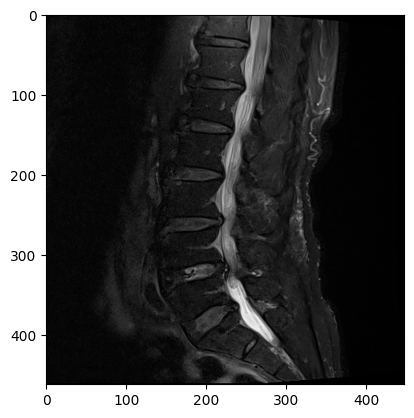

In [97]:
plt.imshow(array[9], cmap="gray")

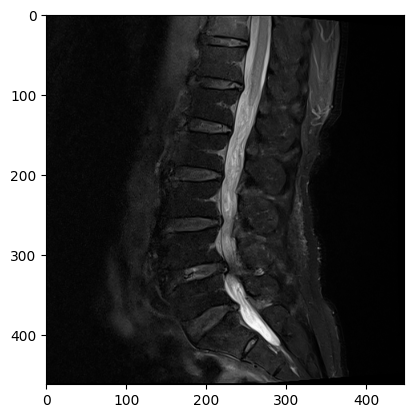

In [86]:
plt.imshow(array[9], cmap="gray")

TypeError: Invalid shape (462, 448, 18) for image data

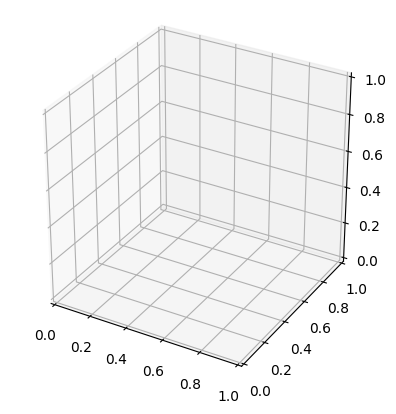

In [79]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.imshow(temp, cmap="plasma", interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])



In [ ]:
###  To Learn and todo
#1. Learn about planes (axis, coronal and sagittal)
#2. How to sort ImagePositionIndex, what is it ??
#2. How to plot 3d ?? Is it possible
#3. Create a datastructure to access these images for training and preprocessing pipeline


